In [1]:
TRAIN =  '/kaggle/input/vegetable-cleaned-segmented/dataset_sayuran_bersih/train'
TEST =  '/kaggle/input/vegetable-cleaned-segmented/dataset_sayuran_bersih/test'
VAL =  '/kaggle/input/vegetable-cleaned-segmented/dataset_sayuran_bersih/val'

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 157MB/s]


In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from os.path import isdir
from PIL import Image

THUMBNAIL_SIZE = (48, 48)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < 100]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') if isdir(folder)}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
test_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TEST + '/*') if isdir(folder)}
test_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in test_dict.items()]))
val_dict = {basename(folder) : folder + '/*.*' for folder in iglob(VAL + '/*') if isdir(folder)}
val_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in val_dict.items()]))
train_df = pd.concat(axis='index', objs=[train_df, val_df])
print('done in {}'.format(arrow.now() - time_start))

encoded 100 rows of Broccoli  in 0:00:13.719790
encoded 100 rows of Capsicum  in 0:00:13.301987
encoded 100 rows of Bottle_Gourd  in 0:00:13.458552
encoded 100 rows of Radish  in 0:00:13.663014
encoded 100 rows of Tomato  in 0:00:13.397301
encoded 100 rows of Brinjal  in 0:00:13.211243
encoded 100 rows of Pumpkin  in 0:00:13.574766
encoded 100 rows of Carrot  in 0:00:13.547028
encoded 100 rows of Papaya  in 0:00:13.529116
encoded 100 rows of Cabbage  in 0:00:13.795875
encoded 100 rows of Bitter_Gourd  in 0:00:13.490194
encoded 100 rows of Cauliflower  in 0:00:13.285440
encoded 100 rows of Bean  in 0:00:13.463492
encoded 100 rows of Cucumber  in 0:00:13.521336
encoded 100 rows of Potato  in 0:00:13.379917
encoded 100 rows of Broccoli  in 0:00:14.050191
encoded 100 rows of Capsicum  in 0:00:13.690848
encoded 100 rows of Bottle_Gourd  in 0:00:13.784051
encoded 100 rows of Radish  in 0:00:13.789978
encoded 100 rows of Tomato  in 0:00:13.685826
encoded 100 rows of Brinjal  in 0:00:14.014955

In [4]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag         Broccoli  Capsicum  Bottle_Gourd    Radish    Tomato   Brinjal  \
proportion  0.066667  0.066667      0.066667  0.066667  0.066667  0.066667   

tag          Pumpkin    Carrot    Papaya   Cabbage  Bitter_Gourd  Cauliflower  \
proportion  0.066667  0.066667  0.066667  0.066667      0.066667     0.066667   

tag             Bean  Cucumber    Potato  
proportion  0.066667  0.066667  0.066667

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
test_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
test_df[['x', 'y']] = test_reducer.fit_transform(X=test_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.007s...
[t-SNE] Computed neighbors for 1500 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 1.987881
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.403297
[t-SNE] KL divergence after 1000 iterations: 0.790982
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.008s...
[t-SNE] Computed neighbors for 1500 samples in 0.221s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 2.073039
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.880234
[t-SNE] KL divergence after 1000 iterations: 0.820089


In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=min(len(train_df) - 1, 10000)))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: veggies', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(train_df['value'].apply(func=pd.Series), train_df['tag'])
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print(classification_report(zero_division=0.0, y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series))))

model fit in 317 iterations
accuracy: 0.9640
f1: 0.9641
              precision    recall  f1-score   support

        Bean       0.95      0.97      0.96       100
Bitter_Gourd       0.93      0.94      0.94       100
Bottle_Gourd       0.97      0.97      0.97       100
     Brinjal       0.95      0.95      0.95       100
    Broccoli       0.97      0.96      0.96       100
     Cabbage       1.00      0.97      0.98       100
    Capsicum       0.98      0.97      0.97       100
      Carrot       1.00      1.00      1.00       100
 Cauliflower       0.97      0.96      0.96       100
    Cucumber       0.94      0.90      0.92       100
      Papaya       0.88      0.99      0.93       100
      Potato       0.99      0.97      0.98       100
     Pumpkin       0.97      1.00      0.99       100
      Radish       0.99      0.99      0.99       100
      Tomato       0.98      0.92      0.95       100

    accuracy                           0.96      1500
   macro avg       0.96 

<Axes: xlabel='probability', ylabel='Count'>

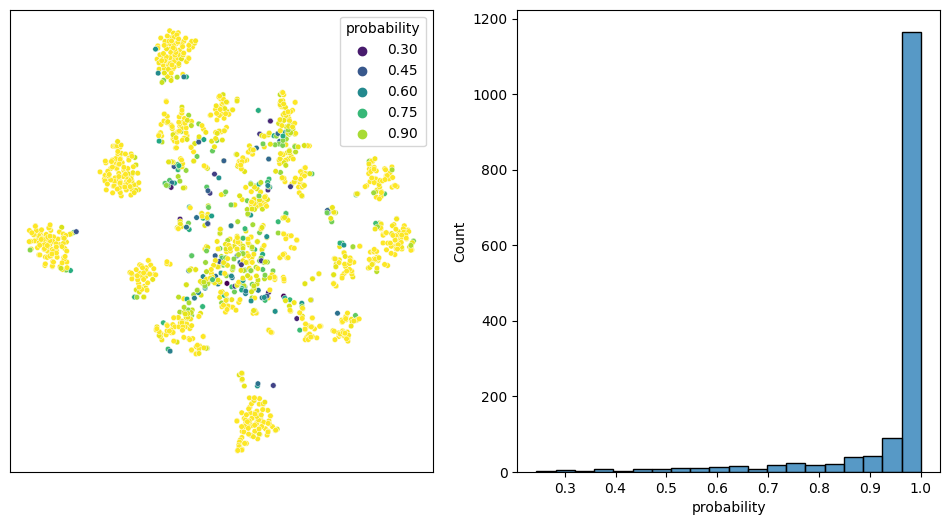

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = test_df[['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=test_df['value'].apply(func=pd.Series)), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis', s=16)
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)